In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torchvision
import numpy as np

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split, WeightedRandomSampler
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


In [2]:
!wget https://raw.githubusercontent.com/abhuse/pytorch-efficientnet/master/efficientnet_v2.py
from efficientnet_v2 import EfficientNetV2

--2022-09-04 09:31:27--  https://raw.githubusercontent.com/abhuse/pytorch-efficientnet/master/efficientnet_v2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30877 (30K) [text/plain]
Saving to: ‘efficientnet_v2.py’

efficientnet_v2.py  100%[===================>]  30.15K  --.-KB/s    in 0.002s  

2022-09-04 09:31:27 (18.7 MB/s) - ‘efficientnet_v2.py’ saved [30877/30877]



In [3]:
# Installing additional package for efficient net
#!pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet

In [4]:
# Data reading
train_csv = pd.read_csv('../input/opencv-pytorch-dl-course-classification/train.csv')
train_data = pd.DataFrame(train_csv)
print("train_data info: ", train_data['class'].value_counts())

train_data info:  chapati        862
nyamachoma     784
bhaji          632
ugali          628
mandazi        620
kachumbari     494
matoke         483
githeri        479
masalachips    438
sukumawiki     402
pilau          329
mukimo         212
kukuchoma      173
Name: class, dtype: int64


In [5]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6536 non-null   uint64
 1   class   6536 non-null   object
dtypes: object(1), uint64(1)
memory usage: 102.2+ KB
None


In [6]:
# Label Encoder function
def label_encoder(df):
    if df["class"] == 'githeri' :
        return 0
    
    elif df["class"] == 'ugali' :
        return 1
    
    elif df["class"] == 'kachumbari' :
        return 2
    
    elif df["class"] == 'matoke':
        return 3
    
    elif df["class"] == 'sukumawiki':
        return 4
    
    elif df['class'] == 'bhaji':
        return 5
    
    elif df['class'] == 'nyamachoma':
        return 6
    
    elif df['class'] == 'mandazi':
        return 7
    
    elif df['class'] == 'pilau':
        return 8
    
    elif df['class'] == 'chapati':
        return 9
    
    elif df['class'] == 'kukuchoma':
        return 10
    
    elif df['class'] == 'masalachips':
        return 11
    
    elif df['class'] == 'mukimo':
        return 12

In [7]:
# Adding labels column 
train_data['labels'] = train_data.apply(label_encoder, axis = 1)
train_data["id"] = train_data["id"].astype(str)
print(train_data)

                        id       class  labels
0     14278962987112149800     githeri       0
1     13190220095752321996       ugali       1
2     10431803432626641638  kachumbari       2
3      4222441716327528413     githeri       0
4      2547906925836120627      matoke       3
...                    ...         ...     ...
6531   9491780363201908054      matoke       3
6532    938716700684692863     chapati       9
6533  12487998559342412135       ugali       1
6534   3466916091782561952  kachumbari       2
6535   4410319397208590457     chapati       9

[6536 rows x 3 columns]


In [8]:
# converting pandas dataframe to csv
train_data.to_csv("train.csv")

In [9]:
# Custom dataloader function
class Kenyafood_data(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations['id'])
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations['id'][index])+'.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        y_label = torch.tensor(int(self.annotations['labels'][index]))
        
        if self.transform is not None:
            image = self.transform(image = image)['image']
            
        return image, y_label

In [10]:
# Necessary transformations for training data
transformations = A.Compose([A.OneOf([
                                      A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.6), 
                                      A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8))
                                     ], p=1),                                
                                A.OneOf([
                                    A.Rotate(limit = 40, p = 0.7),
                                    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.4),
                                    A.MedianBlur(blur_limit=7, always_apply=False, p=0.4),
                                ], p = 1.0),
                             
                                A.OneOf([
                                    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.4),
                                    A.VerticalFlip(p = 0.7),
                                ], p =1.0),
                                 
                                A.OneOf([
                                    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
                                    A.HorizontalFlip(p = 0.7),
                                ], p = 1.0),
                                
                                A.OneOf([
                                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.4),
                                    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.6),
                                ], p=1.0),
                                
                                A.OneOf([
                                    A.Posterize(num_bits=4, always_apply=False, p=0.6),
                                    A.FancyPCA(alpha=0.1, always_apply=False, p=0.4),
                                ], p = 1.0),
                             
                                A.OneOf([
                                    A.Solarize(threshold=128, always_apply=False, p=0.7),
                                    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.3),
                                ], p = 1.0),
                             
                                A.Resize(width = 300, height = 300),
                                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                                ToTensorV2()
                        ])

In [11]:
# Splitting training and validation samples
imageloader = Kenyafood_data(csv_file = "./train.csv", root_dir = "../input/opencv-pytorch-dl-course-classification/images/images",
                                          transform = transformations)
train_sampler, val_sampler =  random_split(imageloader, [5228,1308]) 

In [12]:
# Creating dataloader for training and validation samples
train_samples = DataLoader(train_sampler, batch_size = 16, num_workers = 0, shuffle = True)
val_samples = DataLoader(val_sampler, batch_size = 16, num_workers = 0, shuffle = True)

In [13]:
# Checking the dataloader before training
j = next(iter(train_samples))
print(j[0].size())
print(len(train_samples))

torch.Size([16, 3, 300, 300])
327


In [14]:
# Loading pre-trained model
#res_model = models.efficientnet_b4(pretrained = True)

In [15]:
modelname = 'b3'
res_model = EfficientNetV2(modelname,
                        n_classes=13,
                        pretrained=True)

Downloading: "https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdGlRcHc5VGNjZmlnUVpkamdZUzhhaDdtTTZLP2U9anA4VWN2/root/content" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_b3_21k_ft1k-3da5874c.pth


Model weights loaded successfully.


In [16]:
# Evaluating Accuracy 
def accuracy_score(predictions, labels):
    return (predictions.argmax(dim = 1) == labels).float().mean().item()


In [17]:
# Training function
optimizer = optim.Adam(res_model.parameters(), lr=1e-3, eps=1e-08)
criterion = nn.CrossEntropyLoss()
model = res_model

def Train():
    
    loss_list = []
    acc_list = []
    
    model.cuda()
    model.train()

    for i, (images, labels) in enumerate(train_samples):
        images = images.cuda()

        labels = labels.cuda()

        optimizer.zero_grad()

        prediction = model(images)

        loss = criterion(prediction, labels)

        loss.backward()

        optimizer.step()
        
        prob = F.softmax(prediction, dim = 1)

        loss_list.append(loss.item()) 

        acc = accuracy_score(prob, labels)
        acc_list.append(acc)


    final_loss = sum(loss_list)/len(loss_list)
    final_acc = sum(acc_list)/len(acc_list)

    return final_loss, final_acc
        

In [18]:
# Validation function
def Val():

    acc_list = []
    loss_list = []

    model.eval()
    model.cuda()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_samples):
            images = images.cuda()

            labels = labels.cuda()

            prediction = model(images)

            prob = F.softmax(prediction, dim = 1)

            loss = criterion(prediction, labels)

            loss_list.append(loss.item())

            acc = accuracy_score(prob, labels)
            acc_list.append(acc)


    final_loss = sum(loss_list)/len(loss_list)
    final_acc = sum(acc_list)/len(acc_list)
        
    return final_loss, final_acc

In [19]:
# Training the model
best_acc = 0

train_acc_list = []
val_acc_list = []


for i in range(15):
    train_loss, train_acc = Train()
    print('Epoch: {} \t train Loss: {:.4f} \t train Accuracy: {:.4f}'.format(i, train_loss, train_acc*100))
    val_loss, val_acc = Val()
    print('Epoch: {} \t val Loss: {:.4f} \t val Accuracy: {:.4f}'.format(i, val_loss, val_acc*100))

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
        
    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), './model.pth')
        print('Saved model')




Epoch: 0 	 train Loss: 2.0082 	 train Accuracy: 34.6776
Epoch: 0 	 val Loss: 2.5533 	 val Accuracy: 25.9400
Saved model
Epoch: 1 	 train Loss: 1.7029 	 train Accuracy: 47.0311
Epoch: 1 	 val Loss: 2.1378 	 val Accuracy: 34.4766
Saved model
Epoch: 2 	 train Loss: 1.5825 	 train Accuracy: 49.5731
Epoch: 2 	 val Loss: 1.6530 	 val Accuracy: 48.7551
Saved model
Epoch: 3 	 train Loss: 1.4687 	 train Accuracy: 53.0963
Epoch: 3 	 val Loss: 1.4968 	 val Accuracy: 51.0671
Saved model
Epoch: 4 	 train Loss: 1.4365 	 train Accuracy: 53.4340
Epoch: 4 	 val Loss: 1.7345 	 val Accuracy: 47.9675
Epoch: 5 	 train Loss: 1.3422 	 train Accuracy: 56.4985
Epoch: 5 	 val Loss: 1.4240 	 val Accuracy: 53.6585
Saved model
Epoch: 6 	 train Loss: 1.3123 	 train Accuracy: 57.4732
Epoch: 6 	 val Loss: 1.5040 	 val Accuracy: 51.5498
Epoch: 7 	 train Loss: 1.2330 	 train Accuracy: 60.0089
Epoch: 7 	 val Loss: 1.3511 	 val Accuracy: 56.3262
Saved model
Epoch: 8 	 train Loss: 1.1984 	 train Accuracy: 61.8183
Epoch: 8

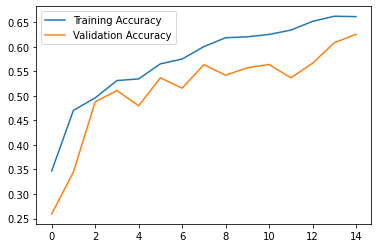

In [20]:
# Plotting the training and validation accuracy
plt.plot(train_acc_list, label = 'Training Accuracy')
plt.plot(val_acc_list, label = 'Validation Accuracy')
plt.legend()
plt.show()


In [21]:
# Converting the predicted class to labels
test_data = pd.read_csv('../input/opencv-pytorch-dl-course-classification/test.csv')
test_data['id'] = test_data['id'].astype(str)
test_data["class"] = ""
test_data

,id,class
0,9156739011499789258,
1,2049465964503133373,
2,6446998501027132988,
3,4194396063119815321,
4,9018117998187006009,
...,...,...
1633,18302448610371772604,
1634,15920672464676076400,
1635,3232020170382870007,
1636,3094804487341098468,


In [22]:
# Decoding int lables to string labels
def label_decoder(df):
    if df== 0:
        return 'githeri'
    
    elif df == 1:
        return 'ugali'
    
    elif df== 2:
        return 'kachumbari'
    
    elif df == 3:
        return 'matoke'
    
    elif df == 4:
        return 'sukumawiki'
    
    elif df== 5:
        return 'bhaji'
    
    elif df == 6:
        return 'nyamachoma'
    
    elif df == 7:
        return 'mandazi'
    
    elif df== 8 :
        return 'pilau'
    
    elif df== 9:
        return 'chapati'
    
    elif df== 10:
        return 'kukuchoma'
    
    elif df== 11:
        return 'masalachips'
    
    elif df== 12:
        return 'mukimo'

In [23]:
# Testing with unseen data and saving the predictions to submission requirements
def Test():
    model.eval()
    with torch.no_grad():
        trained_model = torch.load('./model.pth')
        model.load_state_dict(trained_model)
        for i in range(len(test_data["id"])):
            img_path = os.path.join('../input/opencv-pytorch-dl-course-classification/images/images', str(test_data["id"][i])+'.jpg')
            image = Image.open(img_path)
            transformer =  transforms.Compose([transforms.Resize((300,300)),transforms.ToTensor(), 
                                          transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
            transformed_image = transformer(image).cuda()
            predictions = model(transformed_image.unsqueeze(0))
            predictions = F.softmax(predictions, dim = 1)
            prediction = predictions.argmax(dim = 1)
            test_data["class"][i] = label_decoder(prediction.item())


    test_data.to_csv('submission.csv', index = False)
    
    

In [24]:
  from ipykernel import kernelapp as app


In [25]:
# Running the test
Test()